In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from os import cpu_count
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from sklearn.preprocessing import MinMaxScaler
import secrets
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
rng = np.random.default_rng(0)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
near_zero = 1e-12

def scale_np(x, min=near_zero, max=1. - near_zero):
    x_scaled = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
    x_scaled = x_scaled * (max - min) + min
    return x_scaled

def scale_pt_mat(x, min=near_zero, max=1. - near_zero):
    x_scaled = pt.transpose(x)
    x_scaled = scale_pt(x_scaled, min, max)
    x_scaled = pt.transpose(x_scaled)
    return x_scaled

def scale_pt(x, min=near_zero, max=1. - near_zero):
    x_scaled = (x - pt.min(x, axis=0)) / (pt.max(x, axis=0) - pt.min(x, axis=0))
    x_scaled = x_scaled * (max - min) + min
    return x_scaled

In [3]:
gapminder_series = pd.read_csv("./data/gapminder_quality_of_life_2005_dataset.csv", index_col="country")
gapminder_data = gapminder_series.values
# print(gapminder_data[:6, :4])

gapminder_data = scale_np(gapminder_data)
# print(gapminder_data[:6, :4])

gapminder_data[:, 1] = 1. - gapminder_data[:, 1]
gapminder_data[:, 2] = 1. - gapminder_data[:, 2]
# print(gapminder_data[:6, :4])
X = np.transpose(gapminder_data)
print(f"X: {X[:6, :4]}")
# X = pt.sigmoid(X)
# print(f"X: {X.eval()[:6, :4]}")
print(f"X <= 0: {np.where(X <= 0)}")
print(f"X >= 1: {np.where(X >= 1)}")

X: [[0.00362483 0.04477485 0.06081126 0.36641069]
 [0.38511327 0.86731392 0.77669903 0.96763754]
 [0.81990521 0.97867299 0.94312796 0.97867299]
 [0.36479592 0.83928571 0.75510204 0.97193878]]
X <= 0: (array([], dtype=int64), array([], dtype=int64))
X >= 1: (array([], dtype=int64), array([], dtype=int64))


In [4]:
num_scores, dims = gapminder_data.shape

# alpha_alpha_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)
# alpha_beta_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)

# p_1_alpha_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)
# p_1_beta_prior = np.repeat([4.], dims) + .5 * (rng.random(dims) - .5)

# p_2_alpha_prior = np.repeat([4.], dims) + .5 * (rng.random(dims) - .5)
# p_2_beta_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)

# s_alpha_prior = rng.random(num_scores)
# s_beta_prior = rng.random(num_scores)

prior_sigma_scale = .15

alpha_prior = np.repeat([.75], dims) + .25 * (rng.random(dims) - .5)
print(f"alpha_prior <= 0: {np.where(alpha_prior <= 0)}")
print(f"alpha_prior >= 1: {np.where(alpha_prior >= 1)}")
alpha_sigma_prior = np.sqrt(alpha_prior * (1. - alpha_prior)) * prior_sigma_scale
print(f"alpha_sigma_prior: {alpha_sigma_prior}")

p_1_prior = np.repeat([.3125], dims) + .25 * (rng.random(dims) - .5)
print(f"p_1_prior <= 0: {np.where(p_1_prior <= 0)}")
print(f"p_1_prior >= 1: {np.where(p_1_prior >= 1)}")
p_1_sigma_prior = np.sqrt(p_1_prior * (1. - p_1_prior)) * prior_sigma_scale
print(f"p_1_sigma_prior: {p_1_sigma_prior}")

p_2_prior = np.repeat([.6875], dims) + .25 * (rng.random(dims) - .5)
print(f"p_2_prior <= 0: {np.where(p_2_prior <= 0)}")
print(f"p_2_prior >= 1: {np.where(p_2_prior >= 1)}")
p_2_sigma_prior = np.sqrt(p_2_prior * (1. - p_2_prior)) * prior_sigma_scale
print(f"p_2_sigma_prior: {p_2_sigma_prior}")

# s_prior = np.repeat([.5], num_scores) + .25 * (rng.random(num_scores) - .5)
s_prior = np.mean(X, axis=0)
print(f"s_hyperprior <= 0: {np.where(s_prior <= 0)}")
print(f"s_hyperprior >= 1: {np.where(s_prior >= 1)}")
score_sigma_prior = np.sqrt(s_prior * (1. - s_prior)) * prior_sigma_scale
print(f"score_sigma_prior: {np.mean(score_sigma_prior)}, {np.std(score_sigma_prior)}")

alpha_prior <= 0: (array([], dtype=int64),)
alpha_prior >= 1: (array([], dtype=int64),)
alpha_sigma_prior: [0.06170224 0.06922208 0.07220428 0.07245558]
p_1_prior <= 0: (array([], dtype=int64),)
p_1_prior >= 1: (array([], dtype=int64),)
p_1_sigma_prior: [0.07319004 0.07392606 0.07101358 0.07241556]
p_2_prior <= 0: (array([], dtype=int64),)
p_2_prior >= 1: (array([], dtype=int64),)
p_2_sigma_prior: [0.06884248 0.06041579 0.0634621  0.07439875]
s_hyperprior <= 0: (array([], dtype=int64),)
s_hyperprior >= 1: (array([], dtype=int64),)
score_sigma_prior: 0.06887991293886564, 0.006462992905330034


In [5]:
with pm.Model(coords={
    'dims': list(range(dims)), 
    'scores': list(range(num_scores))
    }) as model:
    point_sigma = pm.TruncatedNormal(
        name="point_sigma", 
        mu=.1, 
        sigma=.1, 
        lower=near_zero, 
        upper=.11 - near_zero
        )
    score_sigma = pm.TruncatedNormal(
        name="score_sigma", 
        mu=.135,
        sigma=.1, 
        lower=near_zero, 
        upper=.145 - near_zero
        )
    # X_reconstruction_sigma = pm.TruncatedNormal(
    #     name="X_reconstruction_sigma", 
    #     mu=.125, 
    #     sigma=.1, 
    #     lower=near_zero, 
    #     upper=.135 - near_zero
    #     )
    X_reconstruction_sigma = pm.TruncatedNormal(
        name="X_reconstruction_sigma", 
        mu=np.repeat(.125, dims),
        sigma=.1,
        lower=near_zero, 
        upper=.135 - near_zero
        )
    alpha = pm.Beta(
        name="alpha", 
        mu=alpha_prior, 
        sigma=point_sigma, 
        )
    p_0 = pm.Deterministic(
        name="p_0", var=.5 * (1. - alpha)
        )
    p_1 = pm.Beta(
        name="p_1", 
        mu=p_1_prior, 
        sigma=point_sigma, 
        )
    p_2 = pm.Beta(
        name="p_2", 
        mu=p_2_prior, 
        sigma=point_sigma, 
        )
    p_3 = pm.Deterministic(
        name="p_3", var=.5 * (1. + alpha)
        )
    s = pm.Beta(
        name="s", 
        mu=s_prior, 
        sigma=score_sigma,
        dims=('scores',)
        )

    Z = pm.math.stack(
        [pt.ones((num_scores,)),
         s,
         s ** 2,
         s ** 3],
         axis=0
    )
    M = pt.as_tensor(
        [[1, -3,  3, -1], 
         [0,  3, -6,  3],
         [0,  0,  3, -3], 
         [0,  0,  0,  1]]
        )
    P = pm.math.stack(
        [pt.transpose(p_0), 
         pt.transpose(p_1), 
         pt.transpose(p_2), 
         pt.transpose(p_3)], 
        axis=1)

    X_reconstruction_mu = pm.math.matmul(pm.math.matmul(P, M), Z)

    # X_reconstruction = pm.Beta(
    #     name=f"X_reconstruction", 
    #     mu=X_reconstruction_mu, 
    #     sigma=X_reconstruction_sigma,
    #     observed=X
    #     )
    for i in range(dims):
        X_reconstruction = pm.Beta(
            name=f"X_reconstruction_{i}", 
            mu=X_reconstruction_mu[i, :], 
            # sigma=np.std(X[i, :]),
            sigma=X_reconstruction_sigma[i],
            observed=X[i, :],
            # shape=(num_scores,)
            )


        # weights = pm.Beta(f"mixture_weights_{i}", 1., 1.)
        # components = [
        #     pm.Uniform.dist(name=f"lower_u_{i}", lower=0., upper=1e-3),
        #     pm.Beta.dist(name=f"X_reconstruction_{i}",mu=X_reconstruction_mu[i, :], sigma=X_reconstruction_sigma),
        #     pm.Uniform.dist(name=f"upper_u_{i}", lower=1. - 1e-3, upper=1.)
        # ]
        # mixture = pm.Mixture(
        #     name=f"Mixture_{i}", 
        #     w=[(1. - weights) / 2., weights, (1. - weights) / 2.], 
        #     comp_dists=components,
        #     observed=X[i, :]
        #     )

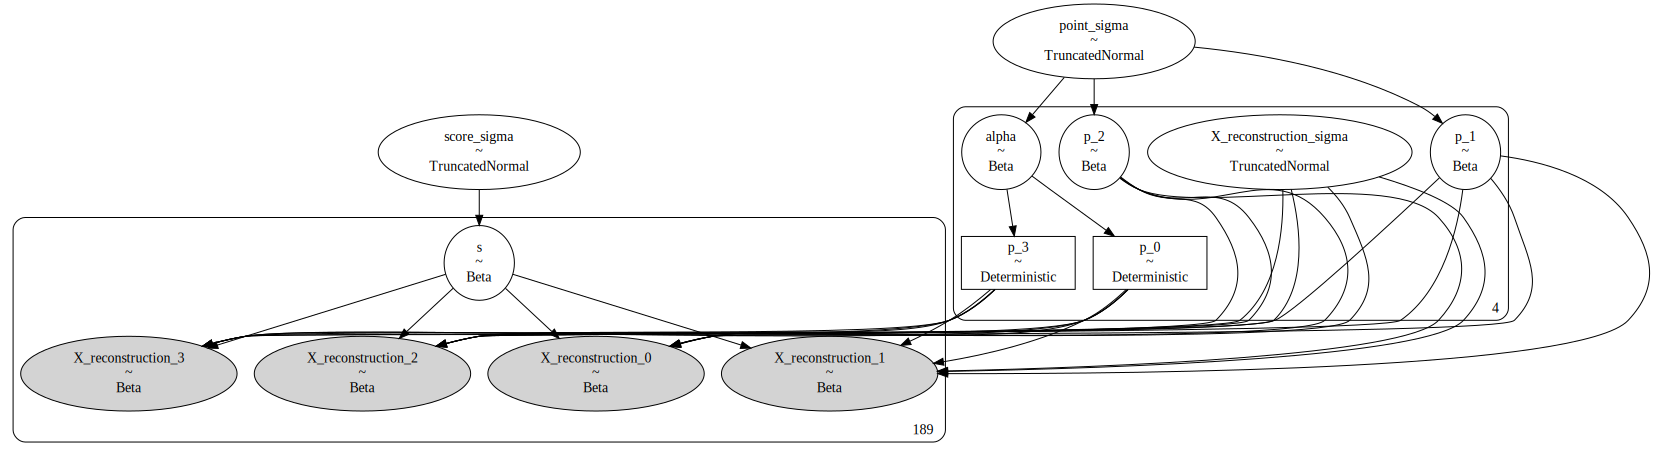

In [6]:
pm.model_to_graphviz(model)

Sampling: [X_reconstruction_0, X_reconstruction_1, X_reconstruction_2, X_reconstruction_3, X_reconstruction_sigma, alpha, p_1, p_2, point_sigma, s, score_sigma]


array([<Axes: xlabel='X_reconstruction_0'>,
       <Axes: xlabel='X_reconstruction_1'>,
       <Axes: xlabel='X_reconstruction_2'>,
       <Axes: xlabel='X_reconstruction_3'>], dtype=object)

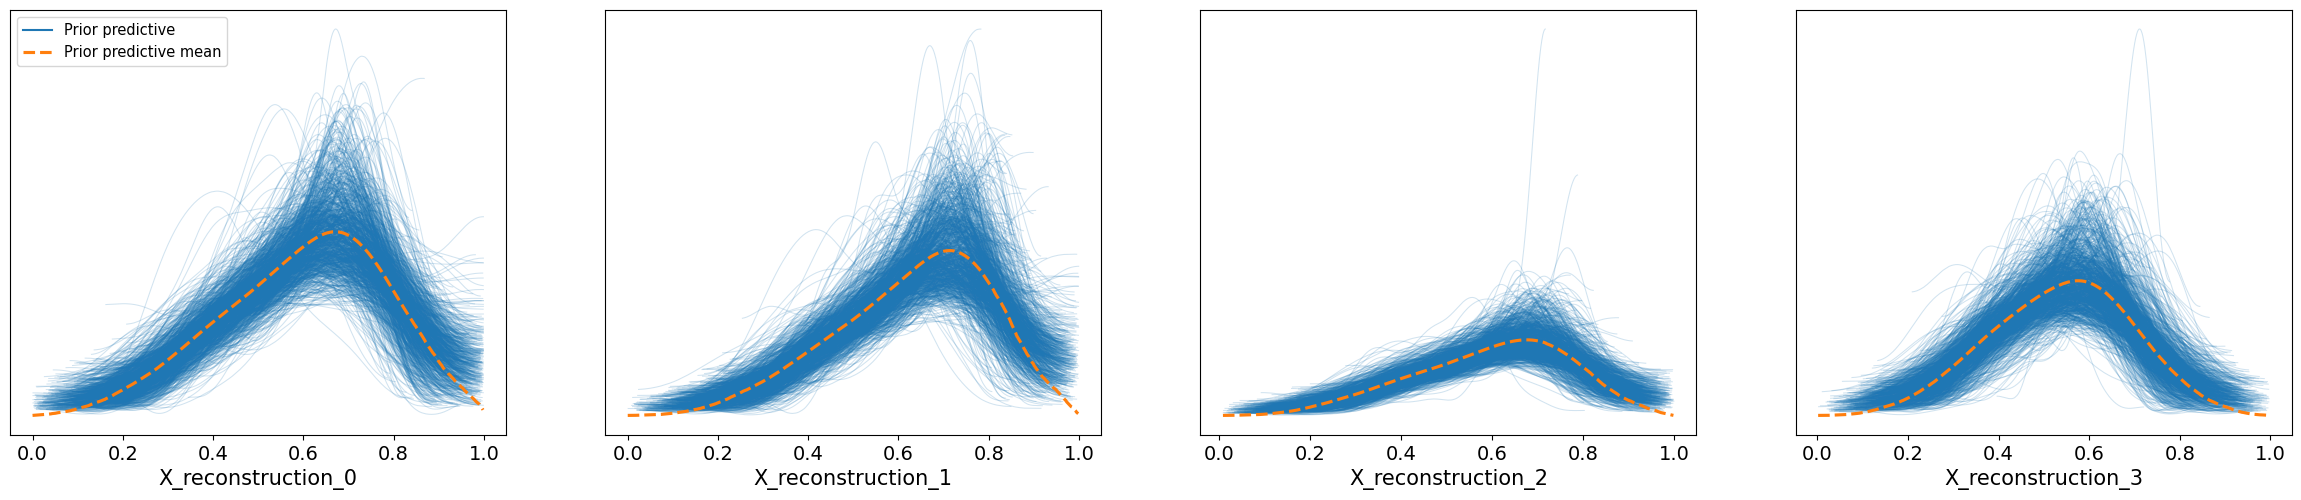

In [7]:
# seed = secrets.randbits(128)
# rng = np.random.default_rng(seed)
with model:
    predictions = pm.sample_prior_predictive(samples=1000, random_seed=rng)
# print(f"seed: {seed}")

az.plot_ppc(predictions, group="prior")

In [8]:
# while True:
#     try:
        # seed = secrets.randbits(128)

        # print(f"seed: {seed}")
        
        # rng = np.random.default_rng(seed)

        # alpha_alpha_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)
        # alpha_beta_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)

        # p_1_alpha_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)
        # p_1_beta_prior = np.repeat([4.], dims) + .5 * (rng.random(dims) - .5)

        # p_2_alpha_prior = np.repeat([4.], dims) + .5 * (rng.random(dims) - .5)
        # p_2_beta_prior = np.repeat([2.], dims) + .5 * (rng.random(dims) - .5)

        # s_alpha_prior = rng.random(num_scores)
        # s_beta_prior = rng.random(num_scores)
    
        # initvals = {
        #         "alpha": alpha_alpha_prior / (alpha_alpha_prior + alpha_beta_prior),
        #         "p_1": p_1_alpha_prior / (p_1_alpha_prior + p_1_beta_prior),
        #         "p_2": p_2_alpha_prior / (p_2_alpha_prior + p_2_beta_prior),
        #         "s": s_alpha_prior / (s_alpha_prior + s_beta_prior)
        #     }
    
initvals = {
    "point_sigma": .1,
    "score_sigma": .135,
    "X_reconstruction_sigma": np.repeat(.125, dims),
    "alpha": alpha_prior,
    "p_1": p_1_prior,
    "p_2": p_2_prior,
    "s": s_prior
    }

with model:
    idata1 = pm.sample(
        nuts_sampler="numpyro",
        nuts_sampler_kwargs={"chain_method": "vectorized"},
        target_accept=.99999,
        random_seed=rng,
        tune=1500,
        draws=1500,
        chains=8,
        cores=8,
        initvals=initvals
    )

    idata1 = pm.sample_posterior_predictive(
        idata1, extend_inferencedata=True, random_seed=rng)
    
    #         print(f"seed: {seed}")

    #         break
    # except pm.SamplingError:
    #     pass


sample: 100%|██████████| 3000/3000 [06:00<00:00,  8.32it/s]
Sampling: [X_reconstruction_0, X_reconstruction_1, X_reconstruction_2, X_reconstruction_3]


Output()

In [9]:

# with model:
#     idata1 = pm.sample_posterior_predictive(
#         idata1, extend_inferencedata=True, random_seed=rng)

date_time = "2024-05-18_1500"
az.to_netcdf(idata1, f"./results/rpc_pymc_{date_time}.nc")

'./results/rpc_pymc_2024-05-18_1500.nc'

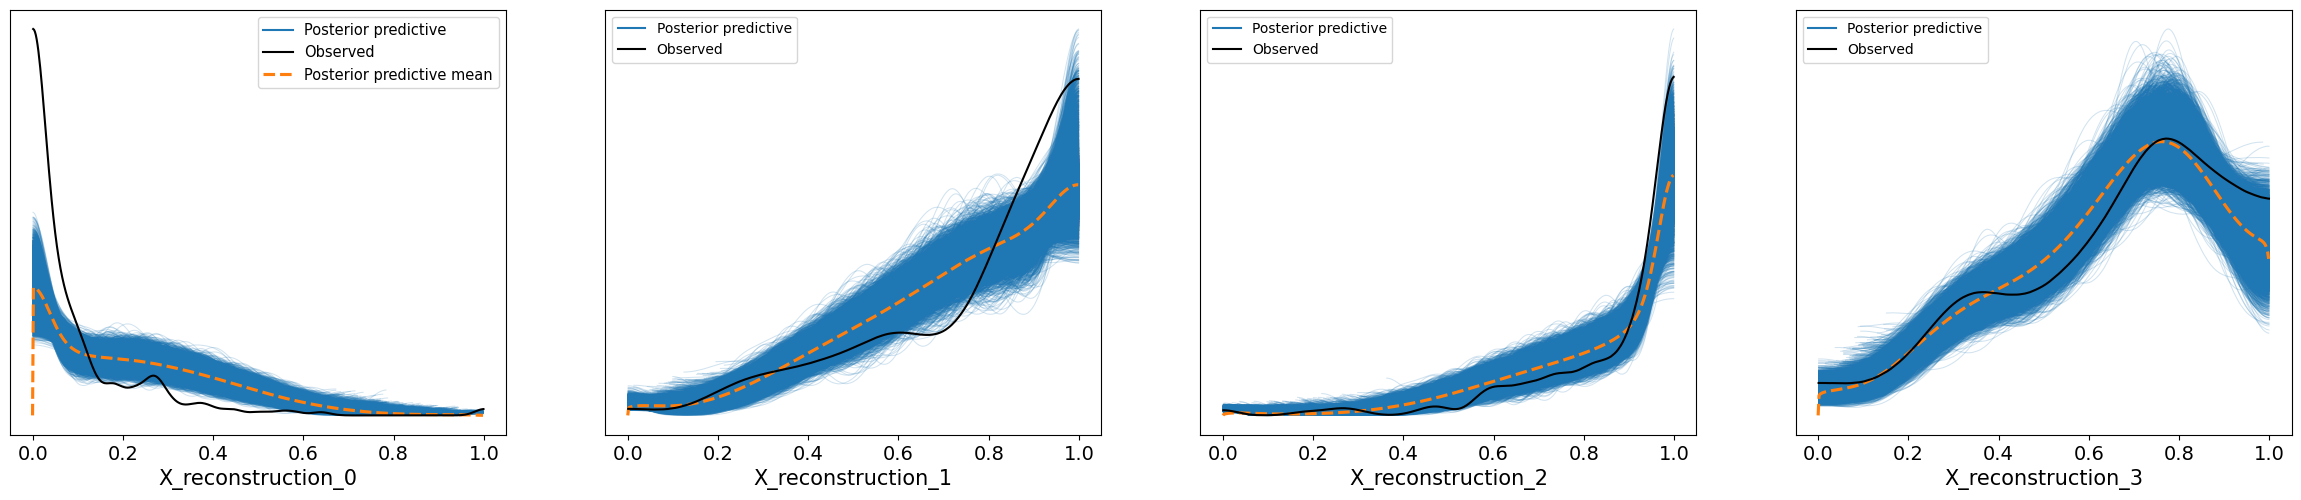

In [10]:
ppc_plot = az.plot_ppc(idata1)
plt.savefig(f'./results/rpc_pymc_{date_time}_ppc_plot.png')

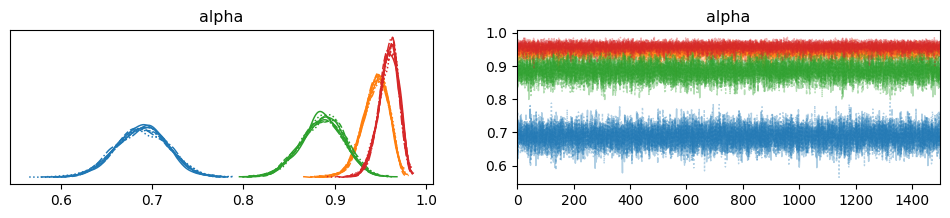

In [11]:
rater_severity_trace_plot = az.plot_trace(idata1, var_names=['alpha'])
fig = rater_severity_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_{date_time}_alpha_trace_plot.png')

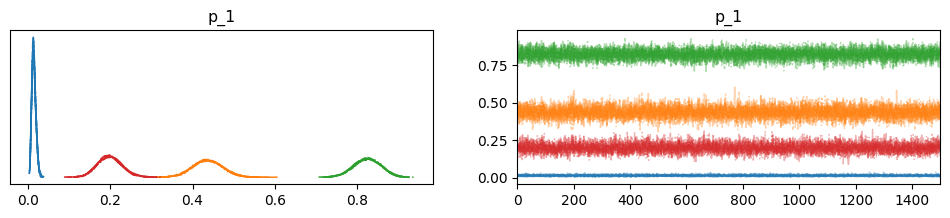

In [12]:
rater_severity_trace_plot = az.plot_trace(idata1, var_names=['p_1'])
fig = rater_severity_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_{date_time}_p_1_trace_plot.png')

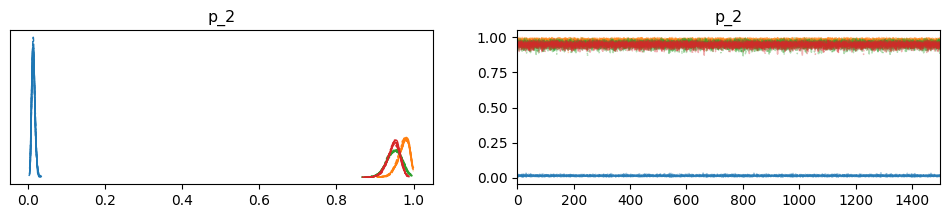

In [13]:
rater_severity_trace_plot = az.plot_trace(idata1, var_names=['p_2'])
fig = rater_severity_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_{date_time}_p_2_trace_plot.png')

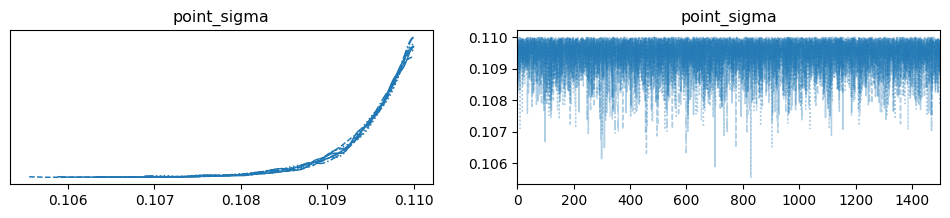

In [14]:
point_sigma_trace_plot = az.plot_trace(idata1, var_names=['point_sigma'])
fig = point_sigma_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_{date_time}_point_sigma_trace_plot.png')

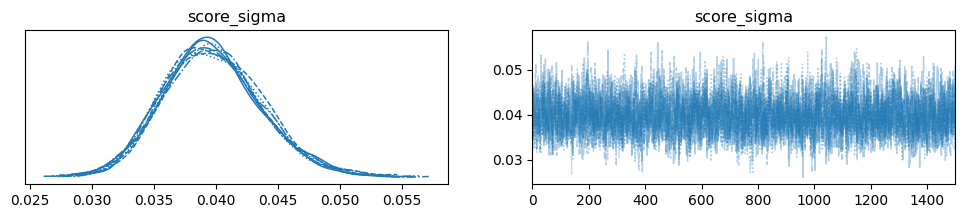

In [15]:
score_sigma_trace_plot = az.plot_trace(idata1, var_names=['score_sigma'])
fig = score_sigma_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_{date_time}_score_sigma_trace_plot.png')

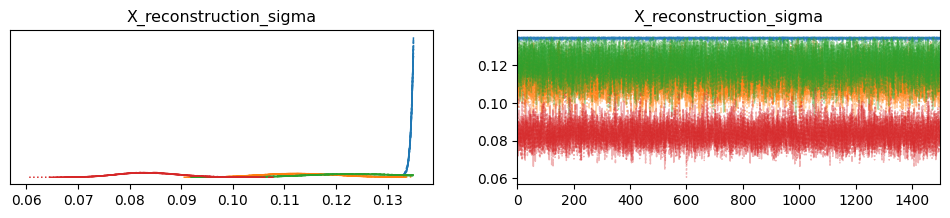

In [16]:
X_reconstruction_sigma_trace_plot = az.plot_trace(idata1, var_names=['X_reconstruction_sigma'])
fig = X_reconstruction_sigma_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_{date_time}_X_reconstruction_sigma_trace_plot.png')

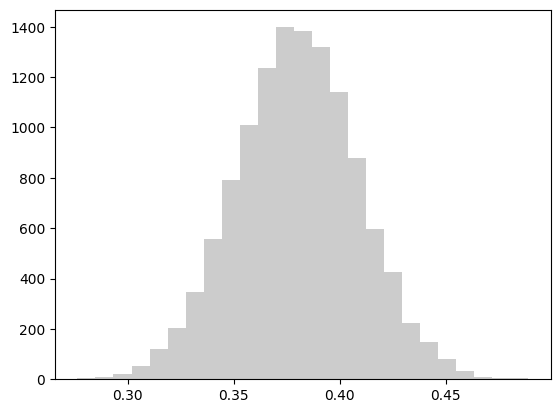

In [17]:
posterior = idata1.posterior.stack(sample=("chain", "draw"))
plt.hist(posterior["s"][0], 25, alpha=0.2, color='k')
plt.savefig(f'./results/rpc_pymc_{date_time}_s_hist_plot.png')

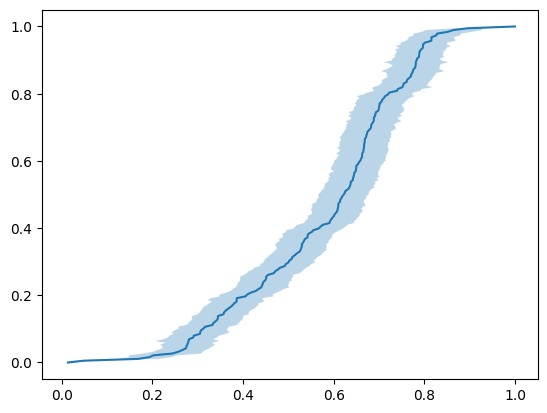

In [24]:
mean_score = idata1.posterior['s'].mean(('chain', 'draw'))
# sorted_scores = idata1.posterior['s'].sortby(mean_examinee_ability)

y = np.linspace(0, 1, len(posterior["s"]))
hdi = az.hdi(idata1.posterior['s']).sortby(mean_score)
plt.plot(mean_score.sortby(mean_score), y)
plt.fill_betweenx(y, hdi['s'].values[:, 0], hdi['s'].values[:, 1], alpha=0.3)
plt.savefig(f'{date_time}_scores_hdi_plot.png')

In [18]:
scores = np.mean(posterior["s"], axis=1)
# gapminder_series.insert(4, "score", scores)
gapminder_series["score"] = scores
gapminder_series

,gdp,imr,it,le,score
country,,,,,
Afghanistan,1350.0,77.4,76,57.6,0.379925
Albania,8150.0,17.8,9,76.2,0.666784
Algeria,10800.0,29.0,24,72.9,0.622115
Andorra,61300.0,5.4,9,81.4,0.815400
Angola,6130.0,101.0,119,56.4,0.304678
...,...,...,...,...,...
Venezuela,17100.0,15.9,18,75.0,0.673357
Vietnam,4920.0,20.0,77,72.8,0.602147
Yemen,4170.0,54.9,37,65.8,0.507568


In [19]:
gapminder_series.sort_values("score", inplace=True, ascending=False)
gapminder_series

,gdp,imr,it,le,score
country,,,,,
Monaco,166000.0,1.4,1,79.0,0.999582
Japan,39000.0,2.8,11,82.5,0.894832
Luxembourg,106000.0,2.8,6,79.5,0.863428
San Marino,83500.0,3.4,3,81.6,0.851231
Singapore,66800.0,2.3,12,81.3,0.827807
...,...,...,...,...,...
Zimbabwe,1840.0,53.9,311,46.8,0.202041
Central African Republic,1000.0,101.0,148,45.2,0.193450
Lesotho,2040.0,72.3,239,43.9,0.168100


In [20]:
gapminder_series.to_csv(f"./data/gapminder_quality_of_life_{date_time}_with_scores.csv")